In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import numpy as np
import random
from vae import VAE
from dataloader import UTKFaceDataset
import seaborn as sns
import pandas as pd
from ae import AutoEncoderNet
from torchvision.utils import make_grid
from sklearn import metrics
from sklearn.cluster import KMeans
from matplotlib import gridspec
from sklearn import metrics


## Dataset and dataloader

In [5]:
BATCH_SIZE = 64
DEVICE = "cpu"

dataset = UTKFaceDataset(data_type="test", gray_scale=False)
test_loader = torch.utils.data.DataLoader(dataset,batch_size= BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

## Load pretrained model

In [115]:
model_path = "models/AutoEncoder_256.pt"
model = AutoEncoderNet(n_channels=3, dim_last_layer=(64, 21, 21), latent_features=256)
model.load_state_dict(torch.load(model_path))
model.to(DEVICE)
model.eval()

AutoEncoderNet(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2))
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(5, 5), stride=(2, 2))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=28224, out_features=512, bias=True)
    (13): ReLU()
    (14): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=28224, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(64, 21, 21))
    (3): ConvTranspose2d(64, 64, kerne

## Reconstruction of test batch

<Figure size 432x288 with 0 Axes>

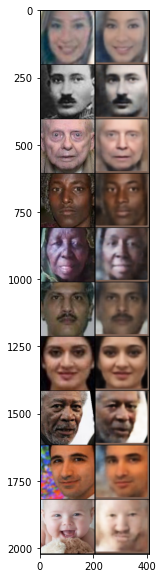

In [12]:

batch = next(iter(test_loader))

plt.figure()
imgs, labels = batch
imgs = imgs[:10]
grid1 = np.asarray(make_grid(imgs,nrow=1).permute(1, 2, 0))
_, rec = model(imgs.to(DEVICE))

grid2 = np.asarray(make_grid(rec.cpu(),nrow=1).permute(1, 2, 0))

plt.figure(figsize=(10,10))
plt.imshow(np.concatenate((grid1,grid2),axis=1))


## Save latent space of test set

In [16]:
zs = []
ys = []
for i, (x, y) in enumerate(test_loader):
    mu = model.encoder(x.to(DEVICE))
    zs.append(mu.detach().cpu())
    ys.append(y.cpu())

z = torch.concat(zs)
y = torch.concat(ys)

np.save("Z.npy", z.numpy())
np.save("Y.npy", y.numpy())


## K-Means Clustering

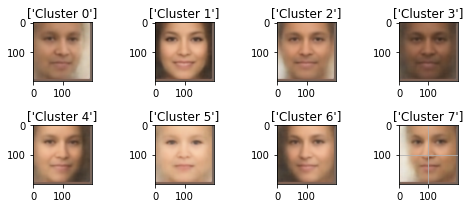

In [24]:
## 8 Clusters
kmeans = KMeans(n_clusters=8)
labels = kmeans.fit_predict(z)


## Visualize cluster centers
C = kmeans.cluster_centers_ # the cluster means
resp = kmeans.labels_ # a vector of the cluster number for each observation

gs = gridspec.GridSpec(2, 4)
fig = plt.figure(figsize=(7,3))
for i in range(len(C)):
    ax = fig.add_subplot(gs[i])
    latent = torch.from_numpy(C[i]).unsqueeze(0).to(DEVICE).float()
    c = model.decoder(latent).detach().cpu().squeeze().permute(1, 2, 0).numpy()
    ax.imshow(c)
    ax.set_title(['Cluster %d' %i])
    ax.set_aspect('equal', adjustable='box')

fig.tight_layout()
plt.show()


Fortolking af clusters:
- Cluster 0 fanger mænd som vender med højre kind mod kamera (lys baggrund)
- Cluster 4 fanger mennesker som vender med højre kind mod kamera  (mørk baggrund)
- Cluster 7 fanger mennesker som vender med venstre kind mod kamera  (lys baggrund)
- Cluster 6 fanger mennesker som vender med venstre kind mod kamera  (mørk baggrund)
- Cluster 3 fanger mørkere hudfarver.
- Cluster 5 fanger børn/babyer
- Cluster 1 fanger kvinder
- Cluster 2 fanger mænd

/homes/hinge/venv/MRI-to-PET/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


Text(0.5, 1.0, 'Within cluster gender distribution')

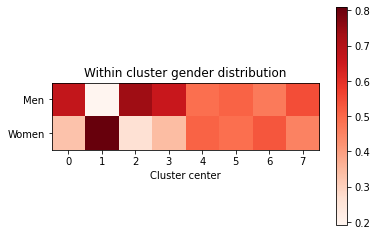

In [33]:
m = metrics.cluster.contingency_matrix(y[:,1], labels)
plt.imshow(m/m.sum(axis=0,keepdims=True),cmap="Reds")
plt.colorbar()
plt.xlabel("Cluster center")
plt.gca().set_yticklabels(["","Men","Women"])
plt.title("Within cluster gender distribution")


/homes/hinge/venv/MRI-to-PET/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  """


Text(0.5, 1.0, 'Within cluster race distribution')

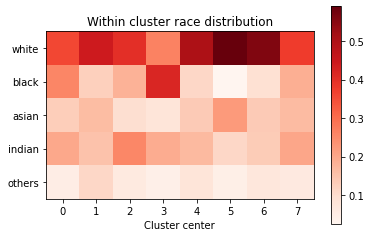

In [36]:
m = metrics.cluster.contingency_matrix(y[:,2], labels)
plt.imshow(m/m.sum(axis=0,keepdims=True),cmap="Reds")
plt.colorbar()
plt.xlabel("Cluster center")
plt.gca().set_yticklabels(["","white", "black", "asian", "indian", "others"])
plt.title("Within cluster race distribution")

Text(0.5, 1.0, 'Age distribution for each cluster')

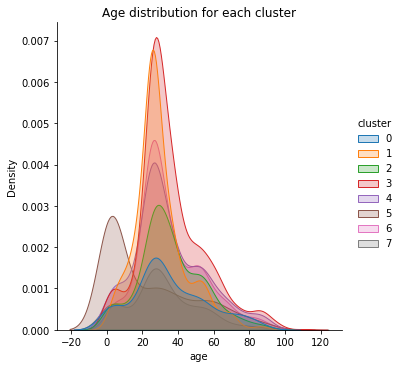

In [50]:
df = pd.DataFrame({"age":y[:,0],"cluster":labels})

sns.displot(df,x="age",hue="cluster",kind="kde", fill=True,palette=sns.color_palette("tab10",8))
plt.title("Age distribution for each cluster")

Her ses det tydeligt at cluster 5 fanger børn

Text(0.5, 1.0, 'Interpolation between two clusters')

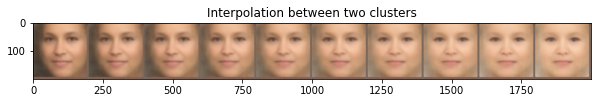

In [56]:
z1 = torch.from_numpy(C[5])
z1 = z1.unsqueeze(0).to(DEVICE)

z2 = torch.from_numpy(C[6])
z2 = z2.unsqueeze(0).to(DEVICE)

alphas = torch.linspace(0,1,steps=10)
model.eval()
plt.figure(figsize=(10,5))

recs = []
for alpha in alphas:
    z_mixed = alpha*z1 + (1-alpha)*z2
    z_mixed = z_mixed.to(DEVICE)
    rec = model.decoder(z_mixed.float())
    rec = rec.squeeze().detach().permute(1, 2, 0).cpu().numpy()
    recs.append(rec)
plt.imshow(np.concatenate(recs,axis=1))
plt.title("Interpolation between two clusters")

## Custom image manipulation

Text(0.5, 1.0, 'Blursed Hinge')

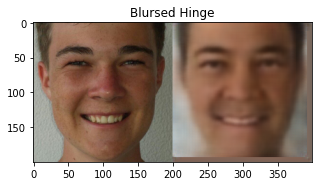

In [114]:
from dataloader import CustomFaceDataset
custom_dataset = CustomFaceDataset()
img = custom_dataset[0]
latent,rec = model(img.unsqueeze(0))
rec = rec.detach().squeeze()

plt.figure(figsize=(5,5))
plt.imshow(np.concatenate((img.permute(1, 2, 0),rec.permute(1, 2, 0)),axis=1))
plt.title("Blursed Hinge")

In [105]:
kmeans.predict(latent.detach().numpy().astype("double"))

array([3], dtype=int32)

Ifølge Kmeans er jeg sort. Må indrømme at jeg havde god tan den sommer

Eksperiment med køn. Jeg interpolerer latent-hinge mod cluster 1, som fanger kvindetræk

Text(0.5, 1.0, 'Feminine Hinge')

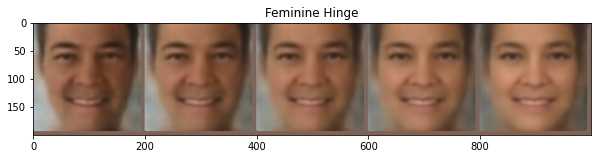

In [112]:
z1 = latent
z2 = torch.from_numpy(C[1])
z2 = z2.unsqueeze(0).to(DEVICE)

alphas = torch.linspace(0,0.5,steps=5)
model.eval()
plt.figure(figsize=(10,5))

recs = []
for alpha in alphas:
    z_mixed = (1-alpha)*z1 + alpha*z2
    z_mixed = z_mixed.to(DEVICE)
    rec = model.decoder(z_mixed.float())
    rec = rec.squeeze().detach().permute(1, 2, 0).cpu().numpy()
    recs.append(rec)
plt.imshow(np.concatenate(recs,axis=1))
plt.title("Feminine Hinge")

## Experiments with GAP statistic
Tyvstjålet fra exercise. Synes ikke det giver noget godt svar lige pt.

In [18]:
X = z.numpy().squeeze()

[N, p] = X.shape

minX = list(np.min(X, axis=0)) # data range min
maxX = list(np.max(X, axis=0)) # data range max

In [19]:
clustersNr = 30
list_of_clusters = range(1,clustersNr + 1,3)
Nsim = 20
Wu = np.zeros((clustersNr, Nsim))
W = np.zeros(clustersNr)
for nrClusters in list_of_clusters: # Want actual number included
    print(nrClusters)
    kmeans = KMeans(n_clusters=nrClusters).fit(X)
    C = kmeans.cluster_centers_ # the cluster centers in the p dimensions
    labelCluster = kmeans.labels_ # the labelling for each point
    
    # Compute within-class dissimilarity given X (the data), C (the cluster centers)
    # and gr (the predicted cluster numbers)
    for cluster in range(1, nrClusters + 1):
        Ik = np.where(labelCluster == cluster - 1)[0]
        dk = np.sum((X[Ik, :] - np.multiply(np.ones((np.size(Ik), 1)), C[cluster - 1, :]))**2, axis = 1)  
        Dk = np.sum(dk)
        W[nrClusters-1] += Dk
    
    
    # gap-statistic
    # Nsim simulations of data uniformly distributed over [X]
    for j in range(Nsim):
        # simulate uniformly distributed data
        Xu = np.ones((N,1))*minX + np.random.rand(N,p)*(np.ones((N,1))*maxX-np.ones((N,1))*minX)
        # perform K-means
        kmeansU = KMeans(n_clusters=nrClusters).fit(Xu)
        Cu = kmeansU.cluster_centers_
        labelClusterU = kmeansU.labels_

        # Compute within-class dissmiliarity for the simulated data given Xu (the simulated data),
        # Cu (the cluster centers for the simulated data), and gru (the predicted cluster numbers)
        # for the simulated data).
        for cluster in range(1, nrClusters+1):
            Iku = np.where(labelClusterU == cluster - 1)
            dku = np.sum((Xu[Iku, :] - np.multiply(np.ones((np.size(Iku), 1)), Cu[cluster - 1, :]))**2, axis = 1)  
            Dku = np.sum(dku)
            Wu[nrClusters - 1, j] += Dku
        
# compute expectation of simulated within-class dissimilarities, and the 
# standard errors for the error bars
Elog_Wu = np.mean(np.log(Wu), axis = 1)
sk = np.std(np.log(Wu), axis=1)*np.sqrt(1+1/Nsim) # standard error sk' in (14.39)
x_range = np.array(range(nrClusters)) + 1

1
4
7
10
13


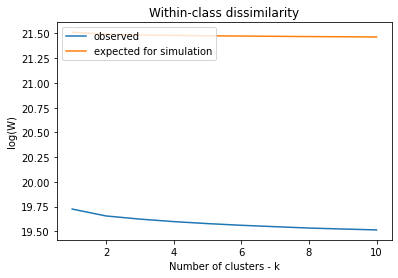

In [26]:
# Plot the log within class scatters
plt.figure()
plt.title("Within-class dissimilarity")
plt.plot(x_range, np.log(W), label='observed')
plt.plot(x_range, Elog_Wu, label='expected for simulation')
plt.legend(loc='upper left')
plt.xlabel("Number of clusters - k")
plt.ylabel("log(W)")
plt.show()

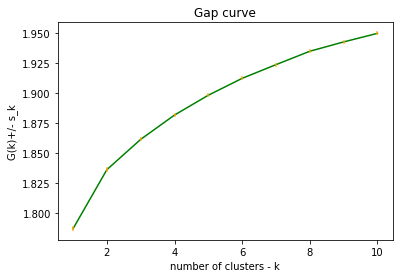

In [27]:
# plot the Gap curve
plt.figure()
plt.title('Gap curve')
Gk =  Elog_Wu.T - np.log(W)
plt.plot(x_range,Gk,color='green')
x_range_list = []
x_range_list.append(x_range)
x_range_list.append(x_range)
GkList = []
GkList.append(Gk-sk)
GkList.append(Gk+sk)
plt.plot(x_range_list, GkList, color='orange')
plt.ylabel('G(k)+/- s_k')
plt.xlabel('number of clusters - k')
plt.show()

In [28]:
# Implementation of the rule for estimating K*, see ESL (14.39), p. 519
K_opt = np.where(np.array(Gk[:-1]) >= np.array(Gk[1:] - sk[1:]))[0]

if not K_opt.size:
    K_opt = clustersNr
    print ("Gap-statistic, optimal K = %d" % K_opt)
else:    
    print ("Gap-statistic, optimal K = %d" % list_of_clusters[K_opt[0]])

Gap-statistic, optimal K = 10
